In [71]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import GRU
from tensorflow import keras
from keras import layers,Input,Model
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers.core import Dense
from keras.layers import LSTM
import sklearn.metrics

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.layers import ConvLSTM2D, ConvLSTM1D
import tensorflow_wavelets.Layers.DWT as DWT
import tensorflow_wavelets.Layers.DTCWT as DTCWT
import tensorflow_wavelets.Layers.DMWT as DMWT
import pywt

In [2]:
dfe = pd.read_csv("elec_14_22.csv",parse_dates = True, delimiter=',', header=0)
dfe['date'] = pd.to_datetime(dfe['date'], format='%Y-%m-%d')
dfe.index = dfe["date"]
del dfe['date']
dfe.head()

,code,e_price,p2,p3,p4,rand,code2
date,,,,,,,
2014-12-05,N4F15,47.20,47.20,47.20,47.20,10,385
2014-12-08,N4F15,46.56,46.56,46.51,46.56,20,525
2014-12-09,N4F15,46.64,46.64,46.64,46.64,0,485
2014-12-10,N4F15,46.53,46.53,46.53,46.53,0,485
2014-12-11,N4F15,46.05,46.05,45.98,45.98,10,475


In [12]:
trainset_size = int(len(dfe['e_price'])*0.8)
valset_size = int(len(dfe['e_price'])*0.1)
testset_size = len(dfe['e_price']) - trainset_size
print("Size of dataset is ", len(dfe['e_price']))
print("Size of training set will be 80% of dataset: ",trainset_size)

Size of dataset is  1918
Size of training set will be 80% of dataset:  1534


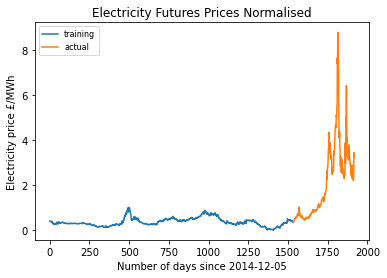

In [6]:
train_max_val = np.max(dfe['e_price'].iloc[:trainset_size])
train_min_val = np.min(dfe['e_price'].iloc[:trainset_size])
max_min_diff = train_max_val - train_min_val
elecs_norm = pd.DataFrame(dfe['e_price']).apply(lambda x:(x-train_min_val)/max_min_diff)
#plot
train = elecs_norm.values[:trainset_size]
test = elecs_norm.values[trainset_size:]
indices = np.arange(trainset_size,len(dfe['e_price']),1)
test_series = pd.Series(test.ravel(), index = indices)
plt.plot(train, label='training')
plt.plot(test_series, label='actual')

plt.title('Electricity Futures Prices Normalised')
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [47]:
observation_size = 10
dataset = keras.utils.timeseries_dataset_from_array(
    data=elecs_norm,
    targets=elecs_norm[observation_size:],
    sequence_length=observation_size,
    batch_size=1,
)
total = elecs_norm.shape[0] - observation_size-1
#shuffled = dataset.shuffle(total)
X_train = dataset.take(trainset_size-observation_size)
X_val =dataset.skip(trainset_size-valset_size-observation_size)
X_test = dataset.skip(trainset_size-observation_size)
model = keras.Sequential()
model.add(LSTM(128, activation='relu', input_shape=(observation_size, 1),return_sequences=True))
model.add(LSTM(128, activation='relu', input_shape=(observation_size, 1), return_sequences=True))
model.add(LSTM(64, activation='relu', input_shape=(observation_size, 1)))
model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))
model.add(Dense(1))
model.compile(optimizer='adagrad', loss='mse', metrics=['mae'])
hist = model.fit(X_train,epochs=15,validation_data=X_val, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

Epoch 1/15
1524/1524 [==============================] - 20s 11ms/step - loss: 0.0415 - mae: 0.1633 - val_loss: 3.5541 - val_mae: 1.1691
Epoch 2/15
1524/1524 [==============================] - 15s 10ms/step - loss: 0.0227 - mae: 0.1121 - val_loss: 3.3177 - val_mae: 1.1226
Epoch 3/15
1524/1524 [==============================] - 15s 10ms/step - loss: 0.0210 - mae: 0.1095 - val_loss: 3.1105 - val_mae: 1.0819
Epoch 4/15
1524/1524 [==============================] - 15s 10ms/step - loss: 0.0197 - mae: 0.1064 - val_loss: 2.8989 - val_mae: 1.0395
Epoch 5/15
1524/1524 [==============================] - 14s 9ms/step - loss: 0.0173 - mae: 0.0992 - val_loss: 2.6531 - val_mae: 0.9885
Epoch 6/15
1524/1524 [==============================] - 14s 9ms/step - loss: 0.0145 - mae: 0.0906 - val_loss: 2.3828 - val_mae: 0.9304
Epoch 7/15
1524/1524 [==============================] - 14s 9ms/step - loss: 0.0124 - mae: 0.0828 - val_loss: 2.0965 - val_mae: 0.8649
Epoch 8/15
1524/1524 [=============================

In [18]:
observation_size = 10
dataset = keras.utils.timeseries_dataset_from_array(
    data=elecs_norm,
    targets=elecs_norm[observation_size:],
    sequence_length=observation_size,
)
for item, label in dataset.take(-1):  # example is (image, label)
  print(item, label)

tf.Tensor(
[[[0.38808966]
  [0.37738374]
  [0.37872198]
  ...
  [0.36232854]
  [0.3743727 ]
  [0.37621278]]

 [[0.37738374]
  [0.37872198]
  [0.3768819 ]
  ...
  [0.3743727 ]
  [0.37621278]
  [0.37085982]]

 [[0.37872198]
  [0.3768819 ]
  [0.36885246]
  ...
  [0.37621278]
  [0.37085982]
  [0.36450318]]

 ...

 [[0.28772165]
  [0.28939445]
  [0.29909669]
  ...
  [0.28772165]
  [0.28822349]
  [0.28320509]]

 [[0.28939445]
  [0.29909669]
  [0.30110405]
  ...
  [0.28822349]
  [0.28320509]
  [0.28571429]]

 [[0.29909669]
  [0.30110405]
  [0.29708933]
  ...
  [0.28320509]
  [0.28571429]
  [0.28889261]]], shape=(128, 10, 1), dtype=float64) tf.Tensor(
[[0.37085982]
 [0.36450318]
 [0.36784878]
 [0.38323854]
 [0.38323854]
 [0.34961526]
 [0.33238541]
 [0.32937437]
 [0.30294413]
 [0.29491469]
 [0.29441285]
 [0.27601204]
 [0.27166276]
 [0.28019404]
 [0.2755102 ]
 [0.29257277]
 [0.29407829]
 [0.28437605]
 [0.26681164]
 [0.24673804]
 [0.24339244]
 [0.25409836]
 [0.25058548]
 [0.24924724]
 [0.25744396

In [20]:
print(elecs_norm.iloc[-1])

e_price    3.255269
Name: 2022-05-16 00:00:00, dtype: float64


In [29]:
def calc_r2(prediction,real,obs_size):
    """
    :param prediction: The forecasted time series
    :param real: The expected time series composed of real observations
    :param obs_size: The window size of
    :return: floating point r2 score <=1
    """
    lstm_diff = prediction.values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    #mask = np.all(np.isnan(lstm_diff),axis=1)
    #lstm_diff = lstm_diff[~mask].reshape(-1,1)
    temp_diff = real.iloc[1:].values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    #mask = np.all(np.isnan(temp_diff),axis=1)
    #temp_diff = temp_diff[~mask].reshape(-1,1)
    return sklearn.metrics.r2_score(temp_diff.reshape(-1,1), lstm_diff.reshape(-1,1))

forecast size  (384, 1)
real size  (385,)
-13.843146259337976


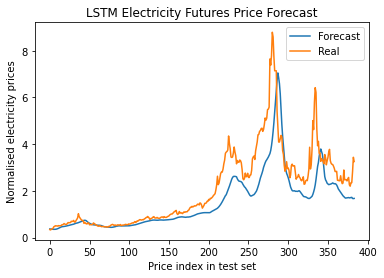

In [48]:
forecast_ar = (model.predict(X_test))
print("forecast size ", forecast_ar.shape)
print("real size ", elecs_norm['e_price'].iloc[trainset_size-1:].shape)
print(calc_r2(pd.Series(forecast_ar.ravel()),pd.Series(elecs_norm['e_price'].iloc[trainset_size-1:]),0))
plt.plot(forecast_ar.ravel(), label='Forecast')
plt.plot(pd.Series(elecs_norm['e_price'].iloc[trainset_size:]).values, label='Real')
plt.xlabel("Price index in test set")
plt.ylabel("Normalised electricity prices")
plt.title("LSTM Electricity Futures Price Forecast")
plt.legend()
plt.show()

In [80]:
arr = []
log_data = np.log(elecs_norm+1)
for i in range(2, len(log_data)):
    a,b = pywt.wavedec(log_data.iloc[:i], 'haar', level=1)
    arr.append(np.array([a[-1],b[-1]]))
dataset = keras.utils.timeseries_dataset_from_array(
    data=arr[:-1],
    targets=arr[observation_size:],
    sequence_length=observation_size,
    batch_size=1,
)

total = elecs_norm.shape[0] - observation_size-1
#shuffled = dataset.shuffle(total)
X_train = dataset.take(trainset_size-observation_size)
X_val =dataset.skip(trainset_size-valset_size-observation_size)
X_test = dataset.skip(trainset_size-observation_size)
model = keras.Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(observation_size, 2),return_sequences=True))
# model.add(LSTM(128, activation='relu', input_shape=(observation_size, 2), return_sequences=True))
# model.add(LSTM(64, activation='relu', input_shape=(observation_size, 2)))
# model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))
model.add(GRU(128, activation='tanh', input_shape=(observation_size, 2), return_sequences=True))
model.add(GRU(128, activation='relu', input_shape=(observation_size, 2)))
model.add(Dense(2))
model.compile(optimizer='adagrad', loss='mse', metrics=['mae'])
hist = model.fit(X_train,epochs=10,validation_data=X_val, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
pred_wavelet = model.predict(dataset)
p = pred_wavelet
pp = [arr[0][0]]
pp2 = [arr[0][1]]
for i in range(1,len(p),2):
    pp.append(p[i][0])
    pp2.append(p[i][1])
forecast_ar = np.exp(pywt.idwt(pp,pp2, 'db1'))-1

Epoch 1/10
1524/1524 [==============================] - 30s 18ms/step - loss: 0.0110 - mae: 0.0649 - val_loss: 0.2914 - val_mae: 0.2991
Epoch 2/10
1524/1524 [==============================] - 14s 9ms/step - loss: 0.0039 - mae: 0.0371 - val_loss: 0.2135 - val_mae: 0.2554
Epoch 3/10
1524/1524 [==============================] - 13s 9ms/step - loss: 0.0026 - mae: 0.0299 - val_loss: 0.1624 - val_mae: 0.2207
Epoch 4/10
1524/1524 [==============================] - 13s 9ms/step - loss: 0.0017 - mae: 0.0247 - val_loss: 0.1294 - val_mae: 0.1960
Epoch 5/10
1524/1524 [==============================] - 27s 17ms/step - loss: 0.0013 - mae: 0.0211 - val_loss: 0.1061 - val_mae: 0.1763
Epoch 6/10
1524/1524 [==============================] - 38s 25ms/step - loss: 9.5568e-04 - mae: 0.0183 - val_loss: 0.0894 - val_mae: 0.1604
Epoch 7/10
1524/1524 [==============================] - 35s 23ms/step - loss: 7.6288e-04 - mae: 0.0161 - val_loss: 0.0772 - val_mae: 0.1475
Epoch 8/10
1524/1524 [=====================

In [52]:
forecast_ar.shape

(1908,)

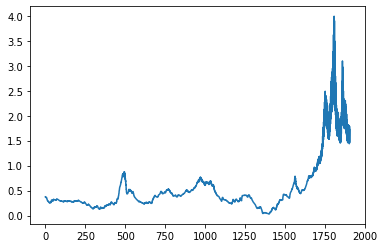

In [81]:
plt.plot(forecast_ar)

forecast size  (1908,)
real size  (385,)
-21.27871360234323


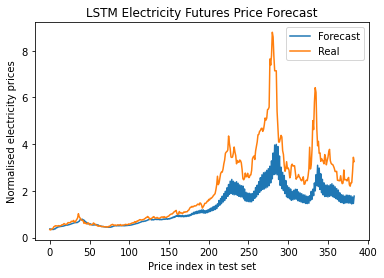

In [82]:
print("forecast size ", forecast_ar.shape)
print("real size ", elecs_norm['e_price'].iloc[trainset_size-1:].shape)
print(calc_r2(pd.Series(forecast_ar.ravel()[-384:]),pd.Series(elecs_norm['e_price'].iloc[trainset_size-1:]),0))
plt.plot(forecast_ar.ravel()[-384:], label='Forecast')
plt.plot(pd.Series(elecs_norm['e_price'].iloc[trainset_size:]).values, label='Real')
plt.xlabel("Price index in test set")
plt.ylabel("Normalised electricity prices")
plt.title("LSTM Electricity Futures Price Forecast")
plt.legend()
plt.show()

In [ ]:
abs = []
cs = []
for i in range(4,len(dfe['e_price'])):
    a,b,c = pywt.wavedec(dfe['e_price'].iloc[:i], 'db1', level=2)
    cs.append(c[-1])
    abs.append([a[-1],b[-1]])
abs = np.array(abs)
cs = np.array(cs)
obs_size = 1
dataset1 = keras.utils.timeseries_dataset_from_array(
    data=abs[:-1],
    targets=abs[obs_size:],
    sequence_length=obs_size,
    batch_size=1,
)
dataset2 = keras.utils.timeseries_dataset_from_array(
    data=cs[:-1],
    targets=cs[obs_size:],
    sequence_length=obs_size,
    batch_size=1,
)

In [ ]:
def make_single_lstm(units, obs_size,var_size):
    model = keras.Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(obs_size, var_size)))
    model.add(Dense(var_size))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
lstm1 = make_single_lstm(64,obs_size,2)
lstm2 = make_single_lstm(64,obs_size,1)
lstm1.fit(dataset1.take(400),epochs=100)
lstm2.fit(dataset2.take(400),epochs=100)

In [ ]:
pred_wavelet = lstm1.predict(dataset1)
pred_wavelet2 = lstm2.predict(dataset2)
p = pred_wavelet
p2 = pred_wavelet2
pp = [abs[0][0]]
pp2 = [abs[0][1]]
pp3 = [cs[0]]
for i in range(1,len(p),2):
    if (i+1)%4 == 0:
        pp.append(p[i][0])
        pp2.append(p[i][1])
    pp3.append(p2[i])
rev = pywt.waverec(([np.array(pp),np.array(pp2),np.array(pp3)]), 'db1')
plt.plot(rev)

In [91]:
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute, Lambda
from keras.layers import TimeDistributed
import tensorflow as tf
from keras import Input
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D, UpSampling1D, UpSampling2D, ZeroPadding1D
# from keras.layers.advanced_activations import ParametricSoftplus, SReLU
from keras.callbacks import ModelCheckpoint, Callback
def ufcnn_model_concat(sequence_length=5000,
                       features=1,
                       nb_filter=150,
                       filter_length=5,
                       output_dim=1,
                       optimizer='adagrad',
                       loss='mse',
                       regression = True,
                       class_mode=None,
                       activation="relu",
                       init="lecun_uniform",
                       wavelet = False):
    #model = tf.keras.Sequential()

    inputs = Input(name='input', shape=(sequence_length,features))
    #########################################################
    #x = ZeroPadding1D(2, name='input_padding') (inputs)# to avoid lookahead bias

    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='valid', kernel_initializer=init, input_shape=(sequence_length, features),name='conv1')(inputs)
    start = Activation(activation, name='relu1')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv2')(start)
    start2 = Activation(activation, name='relu2')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv3')(start2)
    x = Activation(activation, name='relu3')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv4')(x)
    x = Activation(activation, name='relu4')(x)
    #########################################################
    x = tf.keras.layers.concatenate([start2, x], axis=-1)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv5')(x)
    x = Activation(activation, name='relu5')(x)
    #########################################################

    #########################################################
    x = tf.keras.layers.concatenate([start, x], axis=-1)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv6')(x)
    x = Activation(activation, name='relu6')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv7')(x)
    x = LSTM(128)(x)#keras.layers.Flatten()(x)
    #x = Convolution1D(filters=1, kernel_size=1, padding='same', kernel_initializer=init, name='conv8')(x)

    x = Activation('relu', name='relu7')(x)

    # y = LSTM(128,return_sequences=True)(inputs)
    # y = LSTM(64)(y)
    # # y = Dense(1)(y)
    # x = tf.keras.layers.concatenate([x, y], axis=-1)
    x = Dense(output_dim)(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizer, loss='mse')

    return model

In [92]:
model = ufcnn_model_concat(observation_size,2,output_dim=2)
print(model.summary())
hist_u = model.fit(X_train,epochs=10,validation_data=X_val, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
pred_wavelet = model.predict(dataset)
p = pred_wavelet
pp = [arr[0][0]]
pp2 = [arr[0][1]]
for i in range(1,len(p),2):
    pp.append(p[i][0])
    pp2.append(p[i][1])
forecast_ar = np.exp(pywt.idwt(pp,pp2, 'db1'))-1

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 10, 2)]      0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 6, 150)       1650        ['input[0][0]']                  
                                                                                                  
 relu1 (Activation)             (None, 6, 150)       0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv1D)                 (None, 6, 150)       112650      ['relu1[0][0]']                  
                                                                                            

In [89]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 10, 2)]      0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 6, 150)       1650        ['input[0][0]']                  
                                                                                                  
 relu1 (Activation)             (None, 6, 150)       0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv1D)                 (None, 6, 150)       112650      ['relu1[0][0]']                  
                                                                                            

forecast size  (1908,)
real size  (385,)
-44.46729830254948


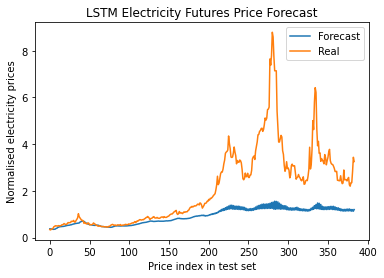

In [93]:
print("forecast size ", forecast_ar.shape)
print("real size ", elecs_norm['e_price'].iloc[trainset_size-1:].shape)
print(calc_r2(pd.Series(forecast_ar.ravel()[-384:]),pd.Series(elecs_norm['e_price'].iloc[trainset_size-1:]),0))
plt.plot(forecast_ar.ravel()[-384:], label='Forecast')
plt.plot(pd.Series(elecs_norm['e_price'].iloc[trainset_size:]).values, label='Real')
plt.xlabel("Price index in test set")
plt.ylabel("Normalised electricity prices")
plt.title("LSTM Electricity Futures Price Forecast")
plt.legend()
plt.show()